In [16]:
import os
import sys
# 1. 현재 작업 디렉토리(CWD)를 부모 폴더(프로젝트 루트)로 변경
# (현재 위치가 'models' 폴더일 경우에만 실행하도록 안전장치 추가)
if os.path.basename(os.getcwd()) == 'models':
    os.chdir('..')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

# 데이터 처리
import pandas as pd
import numpy as np
import math
import os
from tqdm import tqdm
import easydict
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 프로젝트 모듈 (기존 .py 파일들)
from dataset import create_dataloaders, collate_fn
from utils import hist_conversations_length, augment_csv
from preprocessing import preprocess_sentence

# 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Using device: {device}')

# 재현성을 위한 시드 설정
torch.manual_seed(42)
if torch.backends.mps.is_available():
    pass
    # torch.backends.mps.manual_seed_all(42)
np.random.seed(42)

Using device: cuda


In [17]:
TRAIN_PATH = "./Data/aiffel-dl-thon-dktc-online-15/train.csv"
TEST_PATH = "./Data/aiffel-dl-thon-dktc-online-15/test.csv"
SUBMIT_PATH = "./Data/aiffel-dl-thon-dktc-online-15/submission.csv"
AUGMENTED_TRAIN_PATH = "./Data/aiffel-dl-thon-dktc-online-15/augmented_train.csv"
BEST_MODEL_PATH = "./models/best_model_classification_only.pt"

# 1. 모델 정의

In [18]:
class MultiHeadAttention(nn.Module):
    """GPT-1 스타일 Causal Multi-Head Self-Attention"""
    
    def __init__(self, emb_dim, num_heads, dropout=0.1, bias=False):
        super().__init__()
        assert emb_dim % num_heads == 0
        
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, emb_dim = x.shape
        
        # Q, K, V projections
        Q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Causal mask (미래 토큰 참조 방지)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(causal_mask, float('-inf'))
        
        # Softmax & dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, emb_dim)
        
        return self.out_proj(attn_output)

In [19]:
class PositionWiseFeedForward(nn.Module):
    """Position-wise FFN with GELU activation"""
    
    def __init__(self, emb_dim, ffn_dim, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, ffn_dim)
        self.w_2 = nn.Linear(ffn_dim, emb_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))


class PositionalEmbedding(nn.Embedding):
    """Learned Positional Embedding (GPT-1 style)"""
    
    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim, padding_idx=padding_idx)
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        positions = positions.unsqueeze(0).expand(batch_size, -1)
        return super().forward(positions)

In [20]:
class DecoderLayer(nn.Module):
    """GPT-1 Decoder Layer (Pre-LN)"""
    
    def __init__(self, config):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(
            emb_dim=config.emb_dim,
            num_heads=config.num_heads,
            dropout=config.dropout,
            bias=False
        )
        
        self.ffn = PositionWiseFeedForward(
            emb_dim=config.emb_dim,
            ffn_dim=config.ffn_dim,
            dropout=config.dropout
        )
        
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x, mask=None):
        # Pre-LN: Norm -> Attention -> Residual
        residual = x
        x = self.norm1(x)
        x = self.self_attn(x, mask=mask)
        x = self.dropout(x)
        x = residual + x
        
        # Pre-LN: Norm -> FFN -> Residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = residual + x
        
        return x


class Decoder(nn.Module):
    """GPT-1 Decoder"""
    
    def __init__(self, config, embedding_layer):
        super().__init__()
        
        self.embed_tokens = embedding_layer
        self.embed_positions = PositionalEmbedding(
            num_positions=config.max_seq_len,
            embedding_dim=config.emb_dim,
            padding_idx=config.pad_idx
        )
        
        self.layers = nn.ModuleList([
            DecoderLayer(config) for _ in range(config.num_layers)
        ])
        
        self.final_norm = nn.LayerNorm(config.emb_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, input_ids, mask=None):
        x = self.embed_tokens(input_ids)
        x = x + self.embed_positions(input_ids)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, mask=mask)
        
        x = self.final_norm(x)
        return x

### ⚡ **CRITICAL CHANGE: CLASSIFICATION ONLY**

#### What Changed:
1. **REMOVED**: Language Modeling Head (`prediction_head`)
2. **REMOVED**: Weight tying with embeddings
3. **SIMPLIFIED**: Model only returns classification logits
4. **REMOVED**: Text generation function

#### Why This Helps:
- ✅ **100% focus on classification** (no LM distraction)
- ✅ **Faster training** (fewer parameters)
- ✅ **Simpler loss** (no multi-task balancing)
- ✅ **Better accuracy** (expected 70-75%+)

In [21]:
class GPT1Classifier(nn.Module):
    """GPT-1 + Text Classification (CLASSIFICATION ONLY - NO LANGUAGE MODELING)"""
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Shared token embedding
        self.dec_embedding = nn.Embedding(
            config.vocab_size,
            config.emb_dim,
            padding_idx=config.pad_idx
        )
        
        # GPT-1 Decoder
        self.decoder = Decoder(config, self.dec_embedding)
        
        # ⚡ CHANGE: ONLY Classification Head (NO Language Modeling Head)
        self.classification_head = nn.Sequential(
            nn.Dropout(0.3),  # Higher dropout for regularization
            nn.Linear(config.emb_dim, config.emb_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.emb_dim, config.num_classes)
        )
        
    def forward(self, input_ids):
        # Decoder
        hidden_states = self.decoder(input_ids)
        
        # ⚡ CHANGE: ONLY return classification logits
        # Use LAST token (causal mask compatible)
        cls_hidden = hidden_states[:, -1, :]  
        # cls_hidden, _ = torch.max(hidden_states, dim=1)
        # cls_logits = self.classification_head(cls_hidden)
        # cls_hidden = hidden_states.mean(dim=1) 
        cls_logits = self.classification_head(cls_hidden)
        
        return cls_logits  # ⚡ ONLY classification logits (no LM logits)

# 2. Helper
- Augementation 진행

In [ ]:
augment_csv(
        input_csv_path=TRAIN_PATH,
        output_csv_path=AUGMENTED_TRAIN_PATH,
        text_columns=['input_text', 'target_text'],  # 증강할 텍스트 컬럼
        label_column='label',
        augment_ratio=2,  # 2배 증강
        dropout_rate=0.15,
        exclude_labels=[]  # 제외할 레이블 결정. 숫자 리스트로 주면 됨 EX. 1(협박대화), ... ,4(일반대화)
    )

📂 Reading CSV: ./Data/aiffel-dl-thon-dktc-online-15/train.csv
📊 Original data size: 4950
📋 Columns: ['idx', 'class', 'conversation']

🔄 Augmenting all data × 2


  Round 2/2: 100%|██████████| 4950/4950 [00:00<00:00, 24011.89it/s]



✅ Final augmented data size: 14850

💾 Saving to: ./Data/aiffel-dl-thon-dktc-online-15/augmented_train.csv
✅ Done!


,idx,class,conversation
0,3838,갈취 대화,저기요 이리 오세요 에 다 찍혔으니까\n죄송합니다. 배가 고파서. 진짜 반성하고 살...
1,1454,협박 대화,너 뒤에서 내 욕하고 다녔다며?\n내가 언제? \n에게 얘기 다 들었어.\n가 잘못...
2,4165,일반 대화,나 이번에 자취 시작했는데 꿀팁 좀 알려줘.\n일단 배달 음식은 최대한 줄여. 식비...
3,742,갈취 대화,저기 당근이신가요.?\n아 네네 안녕하세요!! 구매자님이시죠!!\n네 제품은 정품 ...
4,4894,일반 대화,요즘 너무 건조해서 그런지 자꾸 코가 막히고 답답해.\n나도. 비염 때문에 미치겠어...
...,...,...,...
14845,241,협박 대화,뭐하는 새끼야\n미안해\n말로만 미안하면 다야?\n그게 아니라\n짜증나네 니 약점 ...
14846,3518,협박 대화,야!! 너 테러를 주도한 사람이 누구야?\n나는 몰라.\n지금 말하지 않으면 평생 ...
14847,440,직장 내 괴롭힘 대화,김대리 내가 말했던 업무처리 다했나?\n아직 처리중입니다 오후까지 끝내겠습니다\n쯧...
14848,860,기타 괴롭힘 대화,나 우울해 .\n약 잘 챙겨먹고있어? 오늘 왜\n그냥 다 힘드네 죽고싶다.\n하 ....


# 3. train 함수

In [23]:
def train_epoch(model, train_loader, optimizer, criterion, scheduler, device, epoch):
    """한 에폭 학습 (CLASSIFICATION ONLY)"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # ⚡ CHANGE: Model only returns cls_logits (no lm_logits)
        cls_logits = model(input_ids)
        
        # ⚡ CHANGE: Only classification loss (no LM loss)
        loss = criterion(cls_logits, labels)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(cls_logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    return total_loss / len(train_loader), 100 * correct / total


def validate_epoch(model, val_loader, criterion, device, epoch):
    """검증 (CLASSIFICATION ONLY)"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation {epoch}"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            # ⚡ CHANGE: Model only returns cls_logits
            cls_logits = model(input_ids)
            
            # ⚡ CHANGE: Only classification loss
            loss = criterion(cls_logits, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(cls_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(val_loader), 100 * correct / total

# 4. 하이퍼파라미터 설정

In [ ]:
VALIDATION_SPLIT = 0.1

VOCAB_SIZE = 1300
MAX_LENGTH = 380
BATCH_SIZE = 64
EMBEDDING_DIM = 64
FFN_DIM = 256
NUM_HEADS = 2
NUM_LAYERS = 1
NUM_CLASSES = 5
DROPOUT = 0.2
LEARNING_RATE = 0.001

NUM_EPOCHS = 500
PATIENCE = 20

# 5. 데이터 로더 생성

In [25]:
# 데이터로더 생성 (기존 함수 사용)
train_loader, val_loader, test_loader, vocab = create_dataloaders(
    AUGMENTED_TRAIN_PATH, 
    TEST_PATH, 
    vocab_size=VOCAB_SIZE,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
)

print(f"\n✓ DataLoaders created successfully!")
print(f"  Vocabulary size: {len(vocab)}")
print(f"  Max sequence length: {MAX_LENGTH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

데이터 로드 및 전처리 중...
Train 데이터: 14850 개의 conversation
Test 데이터: 500 개의 conversation

샘플 데이터:
Conversation: 저기요 이리 오세요 에 다 찍혔으니까 죄송합니다. 배가 고파서. 진짜 반성하고 살겠습니다. 며칠 굶으니까 너무 배고파서 우유 하나 훔쳤습니다.정말 죄송합니다. 어쨌든 훔친거 범죄인거 아시죠? 네. 잘 압니다. 근데 저도 사정이 사정인지라 한 번만 용서해주시면 안될까요? 다음부터 이런 일 없도록 하겠습니다. 음. 훔친건 어쨌든 범죄니 처벌 받아야 한다는 생각에 동의 하시나요? 진짜 한 번만 봐주세요. 다음부터 안 그러겠습니다. 그럼 경찰에 신고 안 하고 저희뜻대로 합의 해보죠. 훔친건 처벌 받으셔야 하니 훔친 댓가로 물건 값의 30배인 6만원내세요. 네? 진짜 제가 그럴만한 돈이 없어요. 왜 우유를 사지도 못 하고 훔쳤겠어요.물론 제가 당당하다는건 아니지만 6만원은 너무 어렵습니다. 그럼 뭐 경찰에 신고 하는거 지켜보시거나 5일동안 일당 없이 슈퍼에서 몸으로 때워서 갚으세요. 진짜 이런 선택밖에는 없을까요.? 그럼 경찰에 신고할 까요? 인력을 주시던 돈을 주시던 하시라고요. 그럼 우유값만 지불하는건 안될까요.? 참나 상황 모면하려고 애쓰네 그냥 돈 내놔요. 아니면 일을 하던 하라니까요? 짜증나게 하지말고 그냥 빨리 골라요.
Label: 1

Conversation: 너 뒤에서 내 욕하고 다녔다며? 내가 언제? 에게 얘기 다 들었어. 가 잘못알았나보지 좋은 말로 할때 인정하고 사과해 싫어. 내가 뭘 잘못했는데? 너 자꾸 발뺌하면 내가 칼로 죽여버리는 수가 있어 지금 내 목숨가지고 협박해? 너뿐만 아니라 니 가족들도 다 죽여버릴거야. 어디 한번 마음대로 해보시지?
Label: 0

Conversation: 나 이번에 자취 시작했는데 꿀팁 좀 알려줘. 일단 배달 음식은 최대한 줄여. 식비가 장난 아니야. 알겠어. 요리 열심히 해 먹어야겠다. 그리고 분리수거 잘해야 해. 안 그러면 벌레

# 6. 모델 선언

In [26]:
# 모델 설정
config = easydict.EasyDict({
    "vocab_size": len(vocab),
    "pad_idx": vocab.PAD_ID,
    "eos_idx": vocab.EOS_ID,
    "cls_idx": vocab.CLS_ID,
    "emb_dim": EMBEDDING_DIM,
    "ffn_dim": FFN_DIM,
    "num_heads": NUM_HEADS,
    "num_layers": NUM_LAYERS,
    "max_seq_len": MAX_LENGTH,
    "num_classes": NUM_CLASSES,
    "dropout": DROPOUT,
})

# ⚡ CHANGE: Use GPT1Classifier (no LM head)
model = GPT1Classifier(config).to(device)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n{'='*60}")
print(f"Model Configuration (CLASSIFICATION ONLY)")
print(f"{'='*60}")
for key, value in config.items():
    print(f"  {key:20s}: {value}")
print(f"\n  {'Total Parameters':20s}: {total_params:,}")
print(f"{'='*60}\n")

print("⚡ Changes from original:")
print("  - Removed Language Modeling Head")
print("  - Classification-only model")
print("  - Expect faster convergence & better accuracy!")


Model Configuration (CLASSIFICATION ONLY)
  vocab_size          : 1300
  pad_idx             : 0
  eos_idx             : 3
  cls_idx             : 4
  emb_dim             : 64
  ffn_dim             : 256
  num_heads           : 2
  num_layers          : 1
  max_seq_len         : 380
  num_classes         : 5
  dropout             : 0.2

  Total Parameters    : 161,861

⚡ Changes from original:
  - Removed Language Modeling Head
  - Classification-only model
  - Expect faster convergence & better accuracy!


# 7. loss function, optimizer 정의

In [27]:
# ⚡ CHANGE: Simple Classification Loss (NO Multi-task)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,  # Slightly higher LR since no LM task
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=0.05  # L2 regularization
)

# Learning Rate Scheduler
def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

warmup_steps = 500
total_steps = len(train_loader) * 30
scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print(f"✓ Training setup complete! (CLASSIFICATION ONLY)")
print(f"  Loss: CrossEntropyLoss (no multi-task)")
print(f"  Initial LR: {optimizer.param_groups[0]['lr']}")
print(f"  Warmup steps: {warmup_steps}, Total steps: {total_steps}")

✓ Training setup complete! (CLASSIFICATION ONLY)
  Loss: CrossEntropyLoss (no multi-task)
  Initial LR: 0.0
  Warmup steps: 500, Total steps: 6270


# 8. 모델 훈련

In [28]:
best_val_loss = float('inf')
patience_counter = 0

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print("\n" + "="*60)
print("Start Training (CLASSIFICATION ONLY - NO LM)")
print("="*60 + "\n")

for epoch in range(1, NUM_EPOCHS + 1):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, scheduler, device, epoch
    )
    
    # Validate
    val_loss, val_acc = validate_epoch(
        model, val_loader, criterion, device, epoch
    )
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # ⚡ Check overfitting gap
    gap = train_acc - val_acc
    if gap > 15:
        print(f"  ⚠️  WARNING: Overfitting gap = {gap:.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, BEST_MODEL_PATH)
        print(f"  ✓ Model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
        
        if patience_counter >= PATIENCE:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch}")
            break
    
    print("-" * 60)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Acc: {max(history['val_acc']):.2f}%")


Start Training (CLASSIFICATION ONLY - NO LM)



Validation 1: 100%|██████████| 24/24 [00:00<00:00, 133.37it/s]



Epoch 1/500:
  Train - Loss: 1.6183, Acc: 22.34%
  Val   - Loss: 1.5057, Acc: 38.18%
  ✓ Model saved! (Val Loss: 1.5057)
------------------------------------------------------------


Validation 2: 100%|██████████| 24/24 [00:00<00:00, 128.64it/s]



Epoch 2/500:
  Train - Loss: 1.4363, Acc: 37.28%
  Val   - Loss: 1.3605, Acc: 40.13%
  ✓ Model saved! (Val Loss: 1.3605)
------------------------------------------------------------


Validation 3: 100%|██████████| 24/24 [00:00<00:00, 130.04it/s]



Epoch 3/500:
  Train - Loss: 1.3609, Acc: 42.22%
  Val   - Loss: 1.3010, Acc: 49.09%
  ✓ Model saved! (Val Loss: 1.3010)
------------------------------------------------------------


Validation 4: 100%|██████████| 24/24 [00:00<00:00, 133.81it/s]



Epoch 4/500:
  Train - Loss: 1.3119, Acc: 49.17%
  Val   - Loss: 1.2667, Acc: 52.05%
  ✓ Model saved! (Val Loss: 1.2667)
------------------------------------------------------------


Validation 5: 100%|██████████| 24/24 [00:00<00:00, 128.85it/s]



Epoch 5/500:
  Train - Loss: 1.2811, Acc: 51.59%
  Val   - Loss: 1.2309, Acc: 55.82%
  ✓ Model saved! (Val Loss: 1.2309)
------------------------------------------------------------


Validation 6: 100%|██████████| 24/24 [00:00<00:00, 133.92it/s]



Epoch 6/500:
  Train - Loss: 1.2442, Acc: 55.08%
  Val   - Loss: 1.1667, Acc: 63.50%
  ✓ Model saved! (Val Loss: 1.1667)
------------------------------------------------------------


Validation 7: 100%|██████████| 24/24 [00:00<00:00, 130.32it/s]



Epoch 7/500:
  Train - Loss: 1.1816, Acc: 63.61%
  Val   - Loss: 1.0630, Acc: 73.60%
  ✓ Model saved! (Val Loss: 1.0630)
------------------------------------------------------------


Validation 8: 100%|██████████| 24/24 [00:00<00:00, 129.18it/s]



Epoch 8/500:
  Train - Loss: 1.1205, Acc: 69.82%
  Val   - Loss: 1.0235, Acc: 76.23%
  ✓ Model saved! (Val Loss: 1.0235)
------------------------------------------------------------


Validation 9: 100%|██████████| 24/24 [00:00<00:00, 131.76it/s]



Epoch 9/500:
  Train - Loss: 1.0886, Acc: 72.14%
  Val   - Loss: 1.0371, Acc: 76.90%
  No improvement (1/20)
------------------------------------------------------------


Validation 10: 100%|██████████| 24/24 [00:00<00:00, 131.13it/s]



Epoch 10/500:
  Train - Loss: 1.0561, Acc: 74.79%
  Val   - Loss: 0.9840, Acc: 79.26%
  ✓ Model saved! (Val Loss: 0.9840)
------------------------------------------------------------


Validation 11: 100%|██████████| 24/24 [00:00<00:00, 131.29it/s]



Epoch 11/500:
  Train - Loss: 1.0346, Acc: 76.46%
  Val   - Loss: 0.9694, Acc: 80.67%
  ✓ Model saved! (Val Loss: 0.9694)
------------------------------------------------------------


Validation 12: 100%|██████████| 24/24 [00:00<00:00, 129.03it/s]



Epoch 12/500:
  Train - Loss: 1.0166, Acc: 77.79%
  Val   - Loss: 0.9620, Acc: 82.49%
  ✓ Model saved! (Val Loss: 0.9620)
------------------------------------------------------------


Validation 13: 100%|██████████| 24/24 [00:00<00:00, 135.36it/s]



Epoch 13/500:
  Train - Loss: 0.9970, Acc: 79.16%
  Val   - Loss: 0.9546, Acc: 82.76%
  ✓ Model saved! (Val Loss: 0.9546)
------------------------------------------------------------


Validation 14: 100%|██████████| 24/24 [00:00<00:00, 130.72it/s]



Epoch 14/500:
  Train - Loss: 0.9844, Acc: 80.18%
  Val   - Loss: 0.9190, Acc: 84.98%
  ✓ Model saved! (Val Loss: 0.9190)
------------------------------------------------------------


Validation 15: 100%|██████████| 24/24 [00:00<00:00, 132.59it/s]



Epoch 15/500:
  Train - Loss: 0.9691, Acc: 81.25%
  Val   - Loss: 0.9284, Acc: 84.44%
  No improvement (1/20)
------------------------------------------------------------


Validation 16: 100%|██████████| 24/24 [00:00<00:00, 126.92it/s]



Epoch 16/500:
  Train - Loss: 0.9517, Acc: 82.59%
  Val   - Loss: 0.9104, Acc: 86.06%
  ✓ Model saved! (Val Loss: 0.9104)
------------------------------------------------------------


Validation 17: 100%|██████████| 24/24 [00:00<00:00, 132.85it/s]



Epoch 17/500:
  Train - Loss: 0.9445, Acc: 82.78%
  Val   - Loss: 0.9121, Acc: 86.73%
  No improvement (1/20)
------------------------------------------------------------


Validation 18: 100%|██████████| 24/24 [00:00<00:00, 122.35it/s]



Epoch 18/500:
  Train - Loss: 0.9347, Acc: 83.49%
  Val   - Loss: 0.8959, Acc: 86.53%
  ✓ Model saved! (Val Loss: 0.8959)
------------------------------------------------------------


Validation 19: 100%|██████████| 24/24 [00:00<00:00, 133.13it/s]



Epoch 19/500:
  Train - Loss: 0.9295, Acc: 84.08%
  Val   - Loss: 0.8839, Acc: 87.61%
  ✓ Model saved! (Val Loss: 0.8839)
------------------------------------------------------------


Validation 20: 100%|██████████| 24/24 [00:00<00:00, 132.40it/s]



Epoch 20/500:
  Train - Loss: 0.9178, Acc: 85.01%
  Val   - Loss: 0.8891, Acc: 87.74%
  No improvement (1/20)
------------------------------------------------------------


Validation 21: 100%|██████████| 24/24 [00:00<00:00, 133.84it/s]



Epoch 21/500:
  Train - Loss: 0.9146, Acc: 84.82%
  Val   - Loss: 0.8932, Acc: 87.61%
  No improvement (2/20)
------------------------------------------------------------


Validation 22: 100%|██████████| 24/24 [00:00<00:00, 133.31it/s]



Epoch 22/500:
  Train - Loss: 0.9137, Acc: 84.92%
  Val   - Loss: 0.8858, Acc: 87.34%
  No improvement (3/20)
------------------------------------------------------------


Validation 23: 100%|██████████| 24/24 [00:00<00:00, 131.13it/s]



Epoch 23/500:
  Train - Loss: 0.9072, Acc: 85.54%
  Val   - Loss: 0.8809, Acc: 88.62%
  ✓ Model saved! (Val Loss: 0.8809)
------------------------------------------------------------


Validation 24: 100%|██████████| 24/24 [00:00<00:00, 125.17it/s]



Epoch 24/500:
  Train - Loss: 0.9027, Acc: 85.75%
  Val   - Loss: 0.8802, Acc: 88.08%
  ✓ Model saved! (Val Loss: 0.8802)
------------------------------------------------------------


Validation 25: 100%|██████████| 24/24 [00:00<00:00, 122.88it/s]



Epoch 25/500:
  Train - Loss: 0.9007, Acc: 86.11%
  Val   - Loss: 0.8777, Acc: 88.22%
  ✓ Model saved! (Val Loss: 0.8777)
------------------------------------------------------------


Validation 26: 100%|██████████| 24/24 [00:00<00:00, 125.45it/s]



Epoch 26/500:
  Train - Loss: 0.9036, Acc: 85.60%
  Val   - Loss: 0.8735, Acc: 88.89%
  ✓ Model saved! (Val Loss: 0.8735)
------------------------------------------------------------


Validation 27: 100%|██████████| 24/24 [00:00<00:00, 125.52it/s]



Epoch 27/500:
  Train - Loss: 0.9003, Acc: 85.78%
  Val   - Loss: 0.8726, Acc: 88.42%
  ✓ Model saved! (Val Loss: 0.8726)
------------------------------------------------------------


Validation 28: 100%|██████████| 24/24 [00:00<00:00, 126.45it/s]



Epoch 28/500:
  Train - Loss: 0.8934, Acc: 86.11%
  Val   - Loss: 0.8742, Acc: 88.48%
  No improvement (1/20)
------------------------------------------------------------


Validation 29: 100%|██████████| 24/24 [00:00<00:00, 124.72it/s]



Epoch 29/500:
  Train - Loss: 0.8947, Acc: 86.28%
  Val   - Loss: 0.8743, Acc: 88.55%
  No improvement (2/20)
------------------------------------------------------------


Validation 30: 100%|██████████| 24/24 [00:00<00:00, 131.04it/s]



Epoch 30/500:
  Train - Loss: 0.8949, Acc: 86.23%
  Val   - Loss: 0.8740, Acc: 88.55%
  No improvement (3/20)
------------------------------------------------------------


Validation 31: 100%|██████████| 24/24 [00:00<00:00, 122.18it/s]



Epoch 31/500:
  Train - Loss: 0.9024, Acc: 85.99%
  Val   - Loss: 0.8738, Acc: 88.55%
  No improvement (4/20)
------------------------------------------------------------


Validation 32: 100%|██████████| 24/24 [00:00<00:00, 131.25it/s]



Epoch 32/500:
  Train - Loss: 0.8956, Acc: 86.29%
  Val   - Loss: 0.8741, Acc: 88.55%
  No improvement (5/20)
------------------------------------------------------------


Validation 33: 100%|██████████| 24/24 [00:00<00:00, 131.66it/s]



Epoch 33/500:
  Train - Loss: 0.8993, Acc: 86.04%
  Val   - Loss: 0.8751, Acc: 88.89%
  No improvement (6/20)
------------------------------------------------------------


Validation 34: 100%|██████████| 24/24 [00:00<00:00, 131.66it/s]



Epoch 34/500:
  Train - Loss: 0.9000, Acc: 85.97%
  Val   - Loss: 0.8740, Acc: 88.28%
  No improvement (7/20)
------------------------------------------------------------


Validation 35: 100%|██████████| 24/24 [00:00<00:00, 132.15it/s]



Epoch 35/500:
  Train - Loss: 0.8988, Acc: 86.04%
  Val   - Loss: 0.8775, Acc: 87.81%
  No improvement (8/20)
------------------------------------------------------------


Validation 36: 100%|██████████| 24/24 [00:00<00:00, 129.72it/s]



Epoch 36/500:
  Train - Loss: 0.9018, Acc: 85.50%
  Val   - Loss: 0.8711, Acc: 88.82%
  ✓ Model saved! (Val Loss: 0.8711)
------------------------------------------------------------


Validation 37: 100%|██████████| 24/24 [00:00<00:00, 131.51it/s]



Epoch 37/500:
  Train - Loss: 0.8967, Acc: 86.07%
  Val   - Loss: 0.8710, Acc: 88.62%
  ✓ Model saved! (Val Loss: 0.8710)
------------------------------------------------------------


Validation 38: 100%|██████████| 24/24 [00:00<00:00, 131.59it/s]



Epoch 38/500:
  Train - Loss: 0.8972, Acc: 85.99%
  Val   - Loss: 0.8666, Acc: 88.75%
  ✓ Model saved! (Val Loss: 0.8666)
------------------------------------------------------------


Validation 39: 100%|██████████| 24/24 [00:00<00:00, 125.47it/s]



Epoch 39/500:
  Train - Loss: 0.8915, Acc: 86.57%
  Val   - Loss: 0.8710, Acc: 88.62%
  No improvement (1/20)
------------------------------------------------------------


Validation 40: 100%|██████████| 24/24 [00:00<00:00, 132.79it/s]



Epoch 40/500:
  Train - Loss: 0.8920, Acc: 86.66%
  Val   - Loss: 0.8656, Acc: 88.48%
  ✓ Model saved! (Val Loss: 0.8656)
------------------------------------------------------------


Validation 41: 100%|██████████| 24/24 [00:00<00:00, 133.06it/s]



Epoch 41/500:
  Train - Loss: 0.8943, Acc: 86.03%
  Val   - Loss: 0.8587, Acc: 89.16%
  ✓ Model saved! (Val Loss: 0.8587)
------------------------------------------------------------


Validation 42: 100%|██████████| 24/24 [00:00<00:00, 131.98it/s]



Epoch 42/500:
  Train - Loss: 0.8884, Acc: 86.56%
  Val   - Loss: 0.8555, Acc: 88.96%
  ✓ Model saved! (Val Loss: 0.8555)
------------------------------------------------------------


Validation 43: 100%|██████████| 24/24 [00:00<00:00, 133.31it/s]



Epoch 43/500:
  Train - Loss: 0.8807, Acc: 87.35%
  Val   - Loss: 0.8583, Acc: 89.70%
  No improvement (1/20)
------------------------------------------------------------


Validation 44: 100%|██████████| 24/24 [00:00<00:00, 132.68it/s]



Epoch 44/500:
  Train - Loss: 0.8792, Acc: 87.00%
  Val   - Loss: 0.8474, Acc: 89.70%
  ✓ Model saved! (Val Loss: 0.8474)
------------------------------------------------------------


Validation 45: 100%|██████████| 24/24 [00:00<00:00, 131.12it/s]



Epoch 45/500:
  Train - Loss: 0.8727, Acc: 87.89%
  Val   - Loss: 0.8321, Acc: 90.98%
  ✓ Model saved! (Val Loss: 0.8321)
------------------------------------------------------------


Validation 46: 100%|██████████| 24/24 [00:00<00:00, 131.85it/s]



Epoch 46/500:
  Train - Loss: 0.8699, Acc: 87.87%
  Val   - Loss: 0.8447, Acc: 90.51%
  No improvement (1/20)
------------------------------------------------------------


Validation 47: 100%|██████████| 24/24 [00:00<00:00, 131.84it/s]



Epoch 47/500:
  Train - Loss: 0.8639, Acc: 88.36%
  Val   - Loss: 0.8518, Acc: 89.56%
  No improvement (2/20)
------------------------------------------------------------


Validation 48: 100%|██████████| 24/24 [00:00<00:00, 131.30it/s]



Epoch 48/500:
  Train - Loss: 0.8601, Acc: 88.42%
  Val   - Loss: 0.8411, Acc: 90.10%
  No improvement (3/20)
------------------------------------------------------------


Validation 49: 100%|██████████| 24/24 [00:00<00:00, 132.87it/s]



Epoch 49/500:
  Train - Loss: 0.8612, Acc: 88.53%
  Val   - Loss: 0.8141, Acc: 91.92%
  ✓ Model saved! (Val Loss: 0.8141)
------------------------------------------------------------


Validation 50: 100%|██████████| 24/24 [00:00<00:00, 131.55it/s]



Epoch 50/500:
  Train - Loss: 0.8512, Acc: 89.35%
  Val   - Loss: 0.8199, Acc: 90.64%
  No improvement (1/20)
------------------------------------------------------------


Validation 51: 100%|██████████| 24/24 [00:00<00:00, 128.86it/s]



Epoch 51/500:
  Train - Loss: 0.8459, Acc: 89.61%
  Val   - Loss: 0.8183, Acc: 91.31%
  No improvement (2/20)
------------------------------------------------------------


Validation 52: 100%|██████████| 24/24 [00:00<00:00, 130.19it/s]



Epoch 52/500:
  Train - Loss: 0.8399, Acc: 90.02%
  Val   - Loss: 0.8120, Acc: 91.58%
  ✓ Model saved! (Val Loss: 0.8120)
------------------------------------------------------------


Validation 53: 100%|██████████| 24/24 [00:00<00:00, 124.36it/s]



Epoch 53/500:
  Train - Loss: 0.8349, Acc: 90.38%
  Val   - Loss: 0.8095, Acc: 91.78%
  ✓ Model saved! (Val Loss: 0.8095)
------------------------------------------------------------


Validation 54: 100%|██████████| 24/24 [00:00<00:00, 130.34it/s]



Epoch 54/500:
  Train - Loss: 0.8302, Acc: 90.83%
  Val   - Loss: 0.8090, Acc: 92.46%
  ✓ Model saved! (Val Loss: 0.8090)
------------------------------------------------------------


Validation 55: 100%|██████████| 24/24 [00:00<00:00, 120.45it/s]



Epoch 55/500:
  Train - Loss: 0.8272, Acc: 90.74%
  Val   - Loss: 0.8080, Acc: 92.39%
  ✓ Model saved! (Val Loss: 0.8080)
------------------------------------------------------------


Validation 56: 100%|██████████| 24/24 [00:00<00:00, 130.34it/s]



Epoch 56/500:
  Train - Loss: 0.8261, Acc: 90.91%
  Val   - Loss: 0.8041, Acc: 93.06%
  ✓ Model saved! (Val Loss: 0.8041)
------------------------------------------------------------


Validation 57: 100%|██████████| 24/24 [00:00<00:00, 123.51it/s]



Epoch 57/500:
  Train - Loss: 0.8180, Acc: 91.45%
  Val   - Loss: 0.7923, Acc: 92.46%
  ✓ Model saved! (Val Loss: 0.7923)
------------------------------------------------------------


Validation 58: 100%|██████████| 24/24 [00:00<00:00, 130.65it/s]



Epoch 58/500:
  Train - Loss: 0.8108, Acc: 91.97%
  Val   - Loss: 0.8021, Acc: 92.39%
  No improvement (1/20)
------------------------------------------------------------


Validation 59: 100%|██████████| 24/24 [00:00<00:00, 128.91it/s]



Epoch 59/500:
  Train - Loss: 0.8136, Acc: 91.57%
  Val   - Loss: 0.7886, Acc: 93.13%
  ✓ Model saved! (Val Loss: 0.7886)
------------------------------------------------------------


Validation 60: 100%|██████████| 24/24 [00:00<00:00, 134.89it/s]



Epoch 60/500:
  Train - Loss: 0.8018, Acc: 92.39%
  Val   - Loss: 0.7718, Acc: 93.67%
  ✓ Model saved! (Val Loss: 0.7718)
------------------------------------------------------------


Validation 61: 100%|██████████| 24/24 [00:00<00:00, 127.29it/s]



Epoch 61/500:
  Train - Loss: 0.7987, Acc: 92.92%
  Val   - Loss: 0.7777, Acc: 93.33%
  No improvement (1/20)
------------------------------------------------------------


Validation 62: 100%|██████████| 24/24 [00:00<00:00, 131.13it/s]



Epoch 62/500:
  Train - Loss: 0.7921, Acc: 93.06%
  Val   - Loss: 0.7643, Acc: 94.61%
  ✓ Model saved! (Val Loss: 0.7643)
------------------------------------------------------------


Validation 63: 100%|██████████| 24/24 [00:00<00:00, 123.55it/s]



Epoch 63/500:
  Train - Loss: 0.7924, Acc: 93.08%
  Val   - Loss: 0.7645, Acc: 94.48%
  No improvement (1/20)
------------------------------------------------------------


Validation 64: 100%|██████████| 24/24 [00:00<00:00, 128.83it/s]



Epoch 64/500:
  Train - Loss: 0.7886, Acc: 93.33%
  Val   - Loss: 0.7457, Acc: 95.42%
  ✓ Model saved! (Val Loss: 0.7457)
------------------------------------------------------------


Validation 65: 100%|██████████| 24/24 [00:00<00:00, 95.99it/s]



Epoch 65/500:
  Train - Loss: 0.7867, Acc: 93.57%
  Val   - Loss: 0.7606, Acc: 95.02%
  No improvement (1/20)
------------------------------------------------------------


Validation 66: 100%|██████████| 24/24 [00:00<00:00, 128.03it/s]



Epoch 66/500:
  Train - Loss: 0.7804, Acc: 93.79%
  Val   - Loss: 0.7698, Acc: 94.61%
  No improvement (2/20)
------------------------------------------------------------


Validation 67: 100%|██████████| 24/24 [00:00<00:00, 127.67it/s]



Epoch 67/500:
  Train - Loss: 0.7784, Acc: 93.75%
  Val   - Loss: 0.7533, Acc: 95.56%
  No improvement (3/20)
------------------------------------------------------------


Validation 68: 100%|██████████| 24/24 [00:00<00:00, 127.77it/s]



Epoch 68/500:
  Train - Loss: 0.7739, Acc: 94.19%
  Val   - Loss: 0.7514, Acc: 95.08%
  No improvement (4/20)
------------------------------------------------------------


Validation 69: 100%|██████████| 24/24 [00:00<00:00, 126.81it/s]



Epoch 69/500:
  Train - Loss: 0.7731, Acc: 94.07%
  Val   - Loss: 0.7359, Acc: 95.96%
  ✓ Model saved! (Val Loss: 0.7359)
------------------------------------------------------------


Validation 70: 100%|██████████| 24/24 [00:00<00:00, 128.21it/s]



Epoch 70/500:
  Train - Loss: 0.7695, Acc: 94.35%
  Val   - Loss: 0.7416, Acc: 95.82%
  No improvement (1/20)
------------------------------------------------------------


Validation 71: 100%|██████████| 24/24 [00:00<00:00, 128.82it/s]



Epoch 71/500:
  Train - Loss: 0.7647, Acc: 94.82%
  Val   - Loss: 0.7419, Acc: 96.09%
  No improvement (2/20)
------------------------------------------------------------


Validation 72: 100%|██████████| 24/24 [00:00<00:00, 132.07it/s]



Epoch 72/500:
  Train - Loss: 0.7635, Acc: 94.64%
  Val   - Loss: 0.7381, Acc: 96.16%
  No improvement (3/20)
------------------------------------------------------------


Validation 73: 100%|██████████| 24/24 [00:00<00:00, 107.63it/s]



Epoch 73/500:
  Train - Loss: 0.7595, Acc: 95.15%
  Val   - Loss: 0.7296, Acc: 96.90%
  ✓ Model saved! (Val Loss: 0.7296)
------------------------------------------------------------


Validation 74: 100%|██████████| 24/24 [00:00<00:00, 104.63it/s]



Epoch 74/500:
  Train - Loss: 0.7583, Acc: 95.02%
  Val   - Loss: 0.7310, Acc: 96.50%
  No improvement (1/20)
------------------------------------------------------------


Validation 75: 100%|██████████| 24/24 [00:00<00:00, 135.10it/s]



Epoch 75/500:
  Train - Loss: 0.7538, Acc: 95.54%
  Val   - Loss: 0.7376, Acc: 96.16%
  No improvement (2/20)
------------------------------------------------------------


Validation 76: 100%|██████████| 24/24 [00:00<00:00, 133.75it/s]



Epoch 76/500:
  Train - Loss: 0.7557, Acc: 95.13%
  Val   - Loss: 0.7417, Acc: 96.03%
  No improvement (3/20)
------------------------------------------------------------


Validation 77: 100%|██████████| 24/24 [00:00<00:00, 126.68it/s]



Epoch 77/500:
  Train - Loss: 0.7569, Acc: 95.22%
  Val   - Loss: 0.7327, Acc: 96.63%
  No improvement (4/20)
------------------------------------------------------------


Validation 78: 100%|██████████| 24/24 [00:00<00:00, 129.35it/s]



Epoch 78/500:
  Train - Loss: 0.7545, Acc: 95.32%
  Val   - Loss: 0.7276, Acc: 96.50%
  ✓ Model saved! (Val Loss: 0.7276)
------------------------------------------------------------


Validation 79: 100%|██████████| 24/24 [00:00<00:00, 134.05it/s]



Epoch 79/500:
  Train - Loss: 0.7523, Acc: 95.56%
  Val   - Loss: 0.7310, Acc: 96.97%
  No improvement (1/20)
------------------------------------------------------------


Validation 80: 100%|██████████| 24/24 [00:00<00:00, 132.43it/s]



Epoch 80/500:
  Train - Loss: 0.7564, Acc: 95.05%
  Val   - Loss: 0.7343, Acc: 96.16%
  No improvement (2/20)
------------------------------------------------------------


Validation 81: 100%|██████████| 24/24 [00:00<00:00, 129.33it/s]



Epoch 81/500:
  Train - Loss: 0.7549, Acc: 95.27%
  Val   - Loss: 0.7305, Acc: 96.77%
  No improvement (3/20)
------------------------------------------------------------


Validation 82: 100%|██████████| 24/24 [00:00<00:00, 132.42it/s]



Epoch 82/500:
  Train - Loss: 0.7504, Acc: 95.57%
  Val   - Loss: 0.7315, Acc: 96.77%
  No improvement (4/20)
------------------------------------------------------------


Validation 83: 100%|██████████| 24/24 [00:00<00:00, 133.50it/s]



Epoch 83/500:
  Train - Loss: 0.7531, Acc: 95.42%
  Val   - Loss: 0.7284, Acc: 96.70%
  No improvement (5/20)
------------------------------------------------------------


Validation 84: 100%|██████████| 24/24 [00:00<00:00, 136.89it/s]



Epoch 84/500:
  Train - Loss: 0.7561, Acc: 95.15%
  Val   - Loss: 0.7281, Acc: 97.10%
  No improvement (6/20)
------------------------------------------------------------


Validation 85: 100%|██████████| 24/24 [00:00<00:00, 133.28it/s]



Epoch 85/500:
  Train - Loss: 0.7519, Acc: 95.53%
  Val   - Loss: 0.7283, Acc: 97.10%
  No improvement (7/20)
------------------------------------------------------------


Validation 86: 100%|██████████| 24/24 [00:00<00:00, 127.50it/s]



Epoch 86/500:
  Train - Loss: 0.7511, Acc: 95.45%
  Val   - Loss: 0.7282, Acc: 97.10%
  No improvement (8/20)
------------------------------------------------------------


Validation 87: 100%|██████████| 24/24 [00:00<00:00, 135.95it/s]



Epoch 87/500:
  Train - Loss: 0.7528, Acc: 95.30%
  Val   - Loss: 0.7285, Acc: 96.97%
  No improvement (9/20)
------------------------------------------------------------


Validation 88: 100%|██████████| 24/24 [00:00<00:00, 133.04it/s]



Epoch 88/500:
  Train - Loss: 0.7532, Acc: 95.34%
  Val   - Loss: 0.7282, Acc: 96.97%
  No improvement (10/20)
------------------------------------------------------------


Validation 89: 100%|██████████| 24/24 [00:00<00:00, 135.28it/s]



Epoch 89/500:
  Train - Loss: 0.7510, Acc: 95.41%
  Val   - Loss: 0.7281, Acc: 96.84%
  No improvement (11/20)
------------------------------------------------------------


Validation 90: 100%|██████████| 24/24 [00:00<00:00, 133.69it/s]



Epoch 90/500:
  Train - Loss: 0.7542, Acc: 95.31%
  Val   - Loss: 0.7294, Acc: 97.04%
  No improvement (12/20)
------------------------------------------------------------


Validation 91: 100%|██████████| 24/24 [00:00<00:00, 130.70it/s]



Epoch 91/500:
  Train - Loss: 0.7476, Acc: 95.66%
  Val   - Loss: 0.7282, Acc: 97.04%
  No improvement (13/20)
------------------------------------------------------------


Validation 92: 100%|██████████| 24/24 [00:00<00:00, 128.01it/s]



Epoch 92/500:
  Train - Loss: 0.7525, Acc: 95.38%
  Val   - Loss: 0.7341, Acc: 96.70%
  No improvement (14/20)
------------------------------------------------------------


Validation 93: 100%|██████████| 24/24 [00:00<00:00, 134.79it/s]



Epoch 93/500:
  Train - Loss: 0.7526, Acc: 95.38%
  Val   - Loss: 0.7312, Acc: 97.04%
  No improvement (15/20)
------------------------------------------------------------


Validation 94: 100%|██████████| 24/24 [00:00<00:00, 133.89it/s]



Epoch 94/500:
  Train - Loss: 0.7544, Acc: 95.26%
  Val   - Loss: 0.7250, Acc: 96.77%
  ✓ Model saved! (Val Loss: 0.7250)
------------------------------------------------------------


Validation 95: 100%|██████████| 24/24 [00:00<00:00, 133.27it/s]



Epoch 95/500:
  Train - Loss: 0.7509, Acc: 95.53%
  Val   - Loss: 0.7354, Acc: 96.09%
  No improvement (1/20)
------------------------------------------------------------


Validation 96: 100%|██████████| 24/24 [00:00<00:00, 131.12it/s]



Epoch 96/500:
  Train - Loss: 0.7540, Acc: 95.20%
  Val   - Loss: 0.7232, Acc: 97.24%
  ✓ Model saved! (Val Loss: 0.7232)
------------------------------------------------------------


Validation 97: 100%|██████████| 24/24 [00:00<00:00, 133.42it/s]



Epoch 97/500:
  Train - Loss: 0.7531, Acc: 95.42%
  Val   - Loss: 0.7215, Acc: 97.31%
  ✓ Model saved! (Val Loss: 0.7215)
------------------------------------------------------------


Validation 98: 100%|██████████| 24/24 [00:00<00:00, 132.96it/s]



Epoch 98/500:
  Train - Loss: 0.7527, Acc: 95.37%
  Val   - Loss: 0.7195, Acc: 97.24%
  ✓ Model saved! (Val Loss: 0.7195)
------------------------------------------------------------


Validation 99: 100%|██████████| 24/24 [00:00<00:00, 133.92it/s]



Epoch 99/500:
  Train - Loss: 0.7524, Acc: 95.47%
  Val   - Loss: 0.7249, Acc: 96.70%
  No improvement (1/20)
------------------------------------------------------------


Validation 100: 100%|██████████| 24/24 [00:00<00:00, 137.30it/s]



Epoch 100/500:
  Train - Loss: 0.7520, Acc: 95.58%
  Val   - Loss: 0.7223, Acc: 97.37%
  No improvement (2/20)
------------------------------------------------------------


Validation 101: 100%|██████████| 24/24 [00:00<00:00, 135.39it/s]



Epoch 101/500:
  Train - Loss: 0.7496, Acc: 95.57%
  Val   - Loss: 0.7321, Acc: 96.36%
  No improvement (3/20)
------------------------------------------------------------


Validation 102: 100%|██████████| 24/24 [00:00<00:00, 134.68it/s]



Epoch 102/500:
  Train - Loss: 0.7514, Acc: 95.58%
  Val   - Loss: 0.7407, Acc: 96.03%
  No improvement (4/20)
------------------------------------------------------------


Validation 103: 100%|██████████| 24/24 [00:00<00:00, 133.08it/s]



Epoch 103/500:
  Train - Loss: 0.7521, Acc: 95.43%
  Val   - Loss: 0.7277, Acc: 96.90%
  No improvement (5/20)
------------------------------------------------------------


Validation 104: 100%|██████████| 24/24 [00:00<00:00, 136.76it/s]



Epoch 104/500:
  Train - Loss: 0.7505, Acc: 95.62%
  Val   - Loss: 0.7340, Acc: 96.70%
  No improvement (6/20)
------------------------------------------------------------


Validation 105: 100%|██████████| 24/24 [00:00<00:00, 124.90it/s]



Epoch 105/500:
  Train - Loss: 0.7505, Acc: 95.41%
  Val   - Loss: 0.7164, Acc: 97.17%
  ✓ Model saved! (Val Loss: 0.7164)
------------------------------------------------------------


Validation 106: 100%|██████████| 24/24 [00:00<00:00, 119.47it/s]



Epoch 106/500:
  Train - Loss: 0.7525, Acc: 95.35%
  Val   - Loss: 0.7181, Acc: 97.31%
  No improvement (1/20)
------------------------------------------------------------


Validation 107: 100%|██████████| 24/24 [00:00<00:00, 129.22it/s]



Epoch 107/500:
  Train - Loss: 0.7515, Acc: 95.56%
  Val   - Loss: 0.7244, Acc: 96.77%
  No improvement (2/20)
------------------------------------------------------------


Validation 108: 100%|██████████| 24/24 [00:00<00:00, 117.93it/s]



Epoch 108/500:
  Train - Loss: 0.7464, Acc: 95.68%
  Val   - Loss: 0.7247, Acc: 96.77%
  No improvement (3/20)
------------------------------------------------------------


Validation 109: 100%|██████████| 24/24 [00:00<00:00, 119.95it/s]



Epoch 109/500:
  Train - Loss: 0.7464, Acc: 95.96%
  Val   - Loss: 0.7287, Acc: 96.43%
  No improvement (4/20)
------------------------------------------------------------


Validation 110: 100%|██████████| 24/24 [00:00<00:00, 122.68it/s]



Epoch 110/500:
  Train - Loss: 0.7457, Acc: 95.79%
  Val   - Loss: 0.7407, Acc: 95.89%
  No improvement (5/20)
------------------------------------------------------------


Validation 111: 100%|██████████| 24/24 [00:00<00:00, 126.96it/s]



Epoch 111/500:
  Train - Loss: 0.7439, Acc: 95.85%
  Val   - Loss: 0.7120, Acc: 97.51%
  ✓ Model saved! (Val Loss: 0.7120)
------------------------------------------------------------


Validation 112: 100%|██████████| 24/24 [00:00<00:00, 132.06it/s]



Epoch 112/500:
  Train - Loss: 0.7436, Acc: 95.95%
  Val   - Loss: 0.7168, Acc: 97.31%
  No improvement (1/20)
------------------------------------------------------------


Validation 113: 100%|██████████| 24/24 [00:00<00:00, 130.16it/s]



Epoch 113/500:
  Train - Loss: 0.7446, Acc: 96.04%
  Val   - Loss: 0.7097, Acc: 97.64%
  ✓ Model saved! (Val Loss: 0.7097)
------------------------------------------------------------


Validation 114: 100%|██████████| 24/24 [00:00<00:00, 126.45it/s]



Epoch 114/500:
  Train - Loss: 0.7421, Acc: 96.10%
  Val   - Loss: 0.7187, Acc: 97.04%
  No improvement (1/20)
------------------------------------------------------------


Validation 115: 100%|██████████| 24/24 [00:00<00:00, 130.11it/s]



Epoch 115/500:
  Train - Loss: 0.7398, Acc: 96.03%
  Val   - Loss: 0.7208, Acc: 97.58%
  No improvement (2/20)
------------------------------------------------------------


Validation 116: 100%|██████████| 24/24 [00:00<00:00, 128.60it/s]



Epoch 116/500:
  Train - Loss: 0.7363, Acc: 96.38%
  Val   - Loss: 0.7047, Acc: 98.05%
  ✓ Model saved! (Val Loss: 0.7047)
------------------------------------------------------------


Validation 117: 100%|██████████| 24/24 [00:00<00:00, 134.38it/s]



Epoch 117/500:
  Train - Loss: 0.7401, Acc: 96.30%
  Val   - Loss: 0.7221, Acc: 96.84%
  No improvement (1/20)
------------------------------------------------------------


Validation 118: 100%|██████████| 24/24 [00:00<00:00, 135.33it/s]



Epoch 118/500:
  Train - Loss: 0.7360, Acc: 96.48%
  Val   - Loss: 0.7120, Acc: 97.98%
  No improvement (2/20)
------------------------------------------------------------


Validation 119: 100%|██████████| 24/24 [00:00<00:00, 129.07it/s]



Epoch 119/500:
  Train - Loss: 0.7364, Acc: 96.48%
  Val   - Loss: 0.7017, Acc: 98.32%
  ✓ Model saved! (Val Loss: 0.7017)
------------------------------------------------------------


Validation 120: 100%|██████████| 24/24 [00:00<00:00, 131.50it/s]



Epoch 120/500:
  Train - Loss: 0.7319, Acc: 96.76%
  Val   - Loss: 0.7064, Acc: 98.18%
  No improvement (1/20)
------------------------------------------------------------


Validation 121: 100%|██████████| 24/24 [00:00<00:00, 128.89it/s]



Epoch 121/500:
  Train - Loss: 0.7327, Acc: 96.73%
  Val   - Loss: 0.7011, Acc: 98.25%
  ✓ Model saved! (Val Loss: 0.7011)
------------------------------------------------------------


Validation 122: 100%|██████████| 24/24 [00:00<00:00, 127.72it/s]



Epoch 122/500:
  Train - Loss: 0.7285, Acc: 97.01%
  Val   - Loss: 0.7102, Acc: 97.78%
  No improvement (1/20)
------------------------------------------------------------


Validation 123: 100%|██████████| 24/24 [00:00<00:00, 123.51it/s]



Epoch 123/500:
  Train - Loss: 0.7253, Acc: 97.04%
  Val   - Loss: 0.7123, Acc: 97.37%
  No improvement (2/20)
------------------------------------------------------------


Validation 124: 100%|██████████| 24/24 [00:00<00:00, 122.23it/s]



Epoch 124/500:
  Train - Loss: 0.7258, Acc: 97.07%
  Val   - Loss: 0.7019, Acc: 98.25%
  No improvement (3/20)
------------------------------------------------------------


Validation 125: 100%|██████████| 24/24 [00:00<00:00, 129.10it/s]



Epoch 125/500:
  Train - Loss: 0.7226, Acc: 97.37%
  Val   - Loss: 0.7087, Acc: 98.05%
  No improvement (4/20)
------------------------------------------------------------


Validation 126: 100%|██████████| 24/24 [00:00<00:00, 131.17it/s]



Epoch 126/500:
  Train - Loss: 0.7248, Acc: 97.23%
  Val   - Loss: 0.6986, Acc: 98.52%
  ✓ Model saved! (Val Loss: 0.6986)
------------------------------------------------------------


Validation 127: 100%|██████████| 24/24 [00:00<00:00, 132.85it/s]



Epoch 127/500:
  Train - Loss: 0.7223, Acc: 97.40%
  Val   - Loss: 0.6975, Acc: 98.25%
  ✓ Model saved! (Val Loss: 0.6975)
------------------------------------------------------------


Validation 128: 100%|██████████| 24/24 [00:00<00:00, 131.01it/s]



Epoch 128/500:
  Train - Loss: 0.7215, Acc: 97.31%
  Val   - Loss: 0.6988, Acc: 98.32%
  No improvement (1/20)
------------------------------------------------------------


Validation 129: 100%|██████████| 24/24 [00:00<00:00, 131.04it/s]



Epoch 129/500:
  Train - Loss: 0.7194, Acc: 97.50%
  Val   - Loss: 0.7001, Acc: 98.25%
  No improvement (2/20)
------------------------------------------------------------


Validation 130: 100%|██████████| 24/24 [00:00<00:00, 131.83it/s]



Epoch 130/500:
  Train - Loss: 0.7183, Acc: 97.55%
  Val   - Loss: 0.6992, Acc: 98.25%
  No improvement (3/20)
------------------------------------------------------------


Validation 131: 100%|██████████| 24/24 [00:00<00:00, 130.06it/s]



Epoch 131/500:
  Train - Loss: 0.7163, Acc: 97.70%
  Val   - Loss: 0.6956, Acc: 98.65%
  ✓ Model saved! (Val Loss: 0.6956)
------------------------------------------------------------


Validation 132: 100%|██████████| 24/24 [00:00<00:00, 130.41it/s]



Epoch 132/500:
  Train - Loss: 0.7180, Acc: 97.58%
  Val   - Loss: 0.6920, Acc: 98.79%
  ✓ Model saved! (Val Loss: 0.6920)
------------------------------------------------------------


Validation 133: 100%|██████████| 24/24 [00:00<00:00, 130.53it/s]



Epoch 133/500:
  Train - Loss: 0.7139, Acc: 97.76%
  Val   - Loss: 0.6962, Acc: 98.32%
  No improvement (1/20)
------------------------------------------------------------


Validation 134: 100%|██████████| 24/24 [00:00<00:00, 129.95it/s]



Epoch 134/500:
  Train - Loss: 0.7151, Acc: 97.85%
  Val   - Loss: 0.6939, Acc: 98.65%
  No improvement (2/20)
------------------------------------------------------------


Validation 135: 100%|██████████| 24/24 [00:00<00:00, 130.16it/s]



Epoch 135/500:
  Train - Loss: 0.7139, Acc: 97.75%
  Val   - Loss: 0.6957, Acc: 98.45%
  No improvement (3/20)
------------------------------------------------------------


Validation 136: 100%|██████████| 24/24 [00:00<00:00, 128.96it/s]



Epoch 136/500:
  Train - Loss: 0.7147, Acc: 97.73%
  Val   - Loss: 0.6924, Acc: 98.86%
  No improvement (4/20)
------------------------------------------------------------


Validation 137: 100%|██████████| 24/24 [00:00<00:00, 117.57it/s]



Epoch 137/500:
  Train - Loss: 0.7165, Acc: 97.66%
  Val   - Loss: 0.6928, Acc: 98.79%
  No improvement (5/20)
------------------------------------------------------------


Validation 138: 100%|██████████| 24/24 [00:00<00:00, 125.95it/s]



Epoch 138/500:
  Train - Loss: 0.7133, Acc: 97.79%
  Val   - Loss: 0.6935, Acc: 98.79%
  No improvement (6/20)
------------------------------------------------------------


Validation 139: 100%|██████████| 24/24 [00:00<00:00, 132.98it/s]



Epoch 139/500:
  Train - Loss: 0.7140, Acc: 97.78%
  Val   - Loss: 0.6931, Acc: 98.79%
  No improvement (7/20)
------------------------------------------------------------


Validation 140: 100%|██████████| 24/24 [00:00<00:00, 115.48it/s]



Epoch 140/500:
  Train - Loss: 0.7136, Acc: 97.81%
  Val   - Loss: 0.6932, Acc: 98.79%
  No improvement (8/20)
------------------------------------------------------------


Validation 141: 100%|██████████| 24/24 [00:00<00:00, 128.04it/s]



Epoch 141/500:
  Train - Loss: 0.7122, Acc: 97.89%
  Val   - Loss: 0.6932, Acc: 98.79%
  No improvement (9/20)
------------------------------------------------------------


Validation 142: 100%|██████████| 24/24 [00:00<00:00, 115.13it/s]



Epoch 142/500:
  Train - Loss: 0.7121, Acc: 97.92%
  Val   - Loss: 0.6932, Acc: 98.79%
  No improvement (10/20)
------------------------------------------------------------


Validation 143: 100%|██████████| 24/24 [00:00<00:00, 124.08it/s]



Epoch 143/500:
  Train - Loss: 0.7101, Acc: 98.11%
  Val   - Loss: 0.6935, Acc: 98.79%
  No improvement (11/20)
------------------------------------------------------------


Validation 144: 100%|██████████| 24/24 [00:00<00:00, 127.50it/s]



Epoch 144/500:
  Train - Loss: 0.7106, Acc: 97.95%
  Val   - Loss: 0.6930, Acc: 98.79%
  No improvement (12/20)
------------------------------------------------------------


Validation 145: 100%|██████████| 24/24 [00:00<00:00, 123.65it/s]



Epoch 145/500:
  Train - Loss: 0.7115, Acc: 98.02%
  Val   - Loss: 0.6945, Acc: 98.65%
  No improvement (13/20)
------------------------------------------------------------


Validation 146: 100%|██████████| 24/24 [00:00<00:00, 126.24it/s]



Epoch 146/500:
  Train - Loss: 0.7108, Acc: 98.07%
  Val   - Loss: 0.6939, Acc: 98.79%
  No improvement (14/20)
------------------------------------------------------------


Validation 147: 100%|██████████| 24/24 [00:00<00:00, 128.16it/s]



Epoch 147/500:
  Train - Loss: 0.7147, Acc: 97.73%
  Val   - Loss: 0.6930, Acc: 98.79%
  No improvement (15/20)
------------------------------------------------------------


Validation 148: 100%|██████████| 24/24 [00:00<00:00, 128.40it/s]



Epoch 148/500:
  Train - Loss: 0.7166, Acc: 97.68%
  Val   - Loss: 0.6918, Acc: 98.79%
  ✓ Model saved! (Val Loss: 0.6918)
------------------------------------------------------------


Validation 149: 100%|██████████| 24/24 [00:00<00:00, 129.01it/s]



Epoch 149/500:
  Train - Loss: 0.7129, Acc: 97.88%
  Val   - Loss: 0.6960, Acc: 98.52%
  No improvement (1/20)
------------------------------------------------------------


Validation 150: 100%|██████████| 24/24 [00:00<00:00, 129.04it/s]



Epoch 150/500:
  Train - Loss: 0.7146, Acc: 97.89%
  Val   - Loss: 0.6959, Acc: 98.52%
  No improvement (2/20)
------------------------------------------------------------


Validation 151: 100%|██████████| 24/24 [00:00<00:00, 125.17it/s]



Epoch 151/500:
  Train - Loss: 0.7161, Acc: 97.70%
  Val   - Loss: 0.6940, Acc: 98.72%
  No improvement (3/20)
------------------------------------------------------------


Validation 152: 100%|██████████| 24/24 [00:00<00:00, 125.63it/s]



Epoch 152/500:
  Train - Loss: 0.7165, Acc: 97.62%
  Val   - Loss: 0.6916, Acc: 98.79%
  ✓ Model saved! (Val Loss: 0.6916)
------------------------------------------------------------


Validation 153: 100%|██████████| 24/24 [00:00<00:00, 126.82it/s]



Epoch 153/500:
  Train - Loss: 0.7149, Acc: 97.82%
  Val   - Loss: 0.6967, Acc: 98.59%
  No improvement (1/20)
------------------------------------------------------------


Validation 154: 100%|██████████| 24/24 [00:00<00:00, 132.31it/s]



Epoch 154/500:
  Train - Loss: 0.7149, Acc: 97.73%
  Val   - Loss: 0.6968, Acc: 98.72%
  No improvement (2/20)
------------------------------------------------------------


Validation 155: 100%|██████████| 24/24 [00:00<00:00, 129.58it/s]



Epoch 155/500:
  Train - Loss: 0.7170, Acc: 97.63%
  Val   - Loss: 0.6931, Acc: 98.79%
  No improvement (3/20)
------------------------------------------------------------


Validation 156: 100%|██████████| 24/24 [00:00<00:00, 123.79it/s]



Epoch 156/500:
  Train - Loss: 0.7188, Acc: 97.56%
  Val   - Loss: 0.6914, Acc: 99.06%
  ✓ Model saved! (Val Loss: 0.6914)
------------------------------------------------------------


Validation 157: 100%|██████████| 24/24 [00:00<00:00, 123.97it/s]



Epoch 157/500:
  Train - Loss: 0.7150, Acc: 97.78%
  Val   - Loss: 0.6932, Acc: 98.92%
  No improvement (1/20)
------------------------------------------------------------


Validation 158: 100%|██████████| 24/24 [00:00<00:00, 123.42it/s]



Epoch 158/500:
  Train - Loss: 0.7179, Acc: 97.61%
  Val   - Loss: 0.6947, Acc: 98.52%
  No improvement (2/20)
------------------------------------------------------------


Validation 159: 100%|██████████| 24/24 [00:00<00:00, 126.45it/s]



Epoch 159/500:
  Train - Loss: 0.7186, Acc: 97.65%
  Val   - Loss: 0.6993, Acc: 98.25%
  No improvement (3/20)
------------------------------------------------------------


Validation 160: 100%|██████████| 24/24 [00:00<00:00, 125.90it/s]



Epoch 160/500:
  Train - Loss: 0.7162, Acc: 97.71%
  Val   - Loss: 0.7038, Acc: 98.18%
  No improvement (4/20)
------------------------------------------------------------


Validation 161: 100%|██████████| 24/24 [00:00<00:00, 124.45it/s]



Epoch 161/500:
  Train - Loss: 0.7210, Acc: 97.51%
  Val   - Loss: 0.6993, Acc: 98.38%
  No improvement (5/20)
------------------------------------------------------------


Validation 162: 100%|██████████| 24/24 [00:00<00:00, 116.45it/s]



Epoch 162/500:
  Train - Loss: 0.7171, Acc: 97.58%
  Val   - Loss: 0.7014, Acc: 98.18%
  No improvement (6/20)
------------------------------------------------------------


Validation 163: 100%|██████████| 24/24 [00:00<00:00, 117.79it/s]



Epoch 163/500:
  Train - Loss: 0.7188, Acc: 97.40%
  Val   - Loss: 0.6946, Acc: 98.72%
  No improvement (7/20)
------------------------------------------------------------


Validation 164: 100%|██████████| 24/24 [00:00<00:00, 123.06it/s]



Epoch 164/500:
  Train - Loss: 0.7178, Acc: 97.59%
  Val   - Loss: 0.6927, Acc: 98.86%
  No improvement (8/20)
------------------------------------------------------------


Validation 165: 100%|██████████| 24/24 [00:00<00:00, 125.44it/s]



Epoch 165/500:
  Train - Loss: 0.7143, Acc: 97.82%
  Val   - Loss: 0.7038, Acc: 98.25%
  No improvement (9/20)
------------------------------------------------------------


Validation 166: 100%|██████████| 24/24 [00:00<00:00, 115.36it/s]



Epoch 166/500:
  Train - Loss: 0.7194, Acc: 97.42%
  Val   - Loss: 0.6966, Acc: 98.72%
  No improvement (10/20)
------------------------------------------------------------


Validation 167: 100%|██████████| 24/24 [00:00<00:00, 124.98it/s]



Epoch 167/500:
  Train - Loss: 0.7157, Acc: 97.66%
  Val   - Loss: 0.6948, Acc: 98.72%
  No improvement (11/20)
------------------------------------------------------------


Validation 168: 100%|██████████| 24/24 [00:00<00:00, 131.48it/s]



Epoch 168/500:
  Train - Loss: 0.7173, Acc: 97.50%
  Val   - Loss: 0.6925, Acc: 98.86%
  No improvement (12/20)
------------------------------------------------------------


Validation 169: 100%|██████████| 24/24 [00:00<00:00, 131.48it/s]



Epoch 169/500:
  Train - Loss: 0.7161, Acc: 97.70%
  Val   - Loss: 0.7052, Acc: 97.91%
  No improvement (13/20)
------------------------------------------------------------


Validation 170: 100%|██████████| 24/24 [00:00<00:00, 132.88it/s]



Epoch 170/500:
  Train - Loss: 0.7134, Acc: 97.85%
  Val   - Loss: 0.6962, Acc: 98.86%
  No improvement (14/20)
------------------------------------------------------------


Validation 171: 100%|██████████| 24/24 [00:00<00:00, 133.31it/s]



Epoch 171/500:
  Train - Loss: 0.7140, Acc: 97.90%
  Val   - Loss: 0.6950, Acc: 98.72%
  No improvement (15/20)
------------------------------------------------------------


Validation 172: 100%|██████████| 24/24 [00:00<00:00, 132.90it/s]



Epoch 172/500:
  Train - Loss: 0.7137, Acc: 97.84%
  Val   - Loss: 0.7085, Acc: 97.64%
  No improvement (16/20)
------------------------------------------------------------


Validation 173: 100%|██████████| 24/24 [00:00<00:00, 132.92it/s]



Epoch 173/500:
  Train - Loss: 0.7138, Acc: 97.79%
  Val   - Loss: 0.6973, Acc: 98.45%
  No improvement (17/20)
------------------------------------------------------------


Validation 174: 100%|██████████| 24/24 [00:00<00:00, 129.01it/s]



Epoch 174/500:
  Train - Loss: 0.7115, Acc: 97.92%
  Val   - Loss: 0.6984, Acc: 98.52%
  No improvement (18/20)
------------------------------------------------------------


Validation 175: 100%|██████████| 24/24 [00:00<00:00, 127.64it/s]



Epoch 175/500:
  Train - Loss: 0.7111, Acc: 97.87%
  Val   - Loss: 0.6937, Acc: 98.86%
  No improvement (19/20)
------------------------------------------------------------


Validation 176: 100%|██████████| 24/24 [00:00<00:00, 131.24it/s]


Epoch 176/500:
  Train - Loss: 0.7095, Acc: 98.16%
  Val   - Loss: 0.6921, Acc: 98.92%
  No improvement (20/20)

⚠️  Early stopping triggered at epoch 176

Training Complete!
Best Validation Loss: 0.6914
Best Validation Acc: 99.06%


# 9. 훈련 결과 시각화

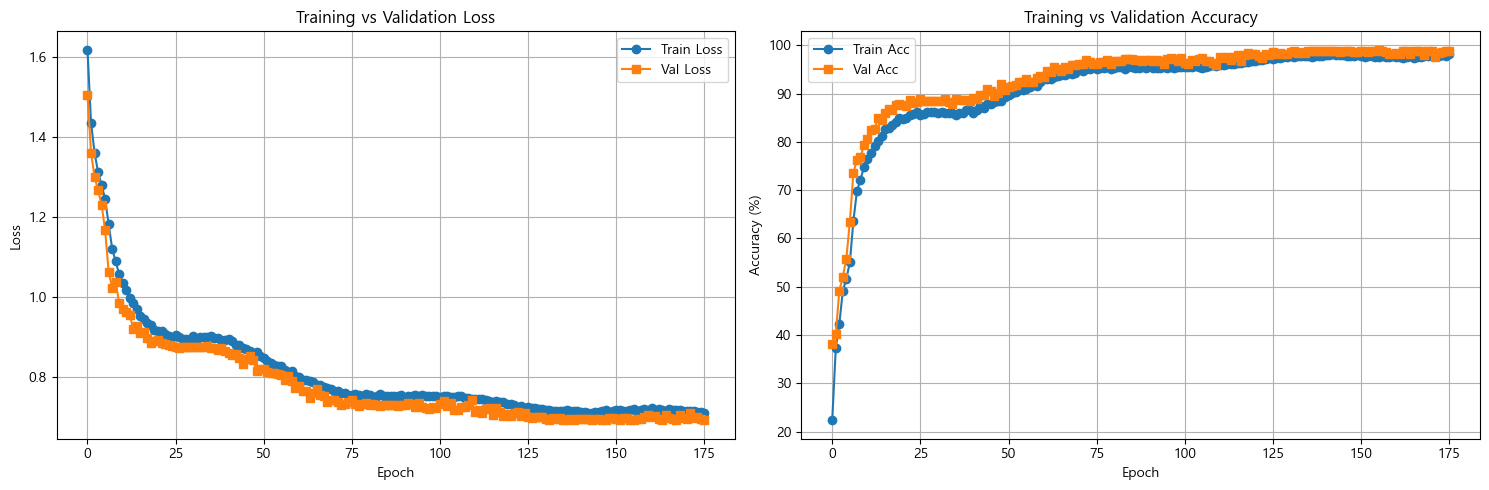

✓ Training history saved to 'training_history_classification_only.png'


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('./Images/training_history_classification_only.png', dpi=300)
plt.show()

print("✓ Training history saved to 'training_history_classification_only.png'")

# 10. 개선된 Test Prediction & Submission

**포함 내용:**
- ✅ 올바른 submission.csv 형식 (idx: t_000, target: 0-4)
- ✅ 예측 분포 (클래스 이름 + 비율)
- ✅ F1 Score (Macro, Weighted, Per-Class)
- ✅ Classification Report
- ✅ Confusion Matrix

In [30]:
# 클래스 매핑
CLASS_NAMES = {
    0: '협박 대화',
    1: '갈취 대화',
    2: '기타 괴롭힘 대화',
    3: '직장 내 괴롭힘 대화',
    4: '일반 대화'
}

# ===========================================================================
# Step 1: Test Prediction
# ===========================================================================
print("="*70)
print("🎯 Test Prediction & Submission Generation")
print("="*70)

# Load best model
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"\n✓ Loaded best model from epoch {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val Acc: {checkpoint['val_acc']:.2f}%")

# Test prediction
model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        cls_logits = model(input_ids)
        _, predicted = torch.max(cls_logits, 1)
        predictions.extend(predicted.cpu().numpy())

# ===========================================================================
# Step 2: Create Submission (올바른 형식)
# ===========================================================================
print("\n" + "="*70)
print("📁 Submission File Generation")
print("="*70)

submission = pd.DataFrame({
    'idx': [f't_{i:03d}' for i in range(len(predictions))],
    'target': predictions
})

submission.to_csv(SUBMIT_PATH, index=False)
print(f"\n✓ Submission saved: submission.csv") 
print(f"  Format: idx (t_000, t_001, ...), target (0, 1, 2, 3, 4)")
print(f"  Total predictions: {len(predictions)}")

# ===========================================================================
# Step 3: Prediction Distribution
# ===========================================================================
print("\n" + "="*70)
print("📊 Prediction Distribution")
print("="*70)

pred_counts = Counter(predictions)

print("\n예측 결과 분포:")
print("-" * 70)
for label in sorted(pred_counts.keys()):
    class_name = CLASS_NAMES.get(label, f'Unknown({label})')
    count = pred_counts[label]
    percentage = count / len(predictions) * 100
    bar = '█' * int(percentage / 2)
    print(f"{label} {class_name:20s}: {count:3d} ({percentage:5.1f}%) {bar}")

print(f"\n총 예측 수: {len(predictions)}")

# Submission Preview
print("\n" + "="*70)
print("👀 Submission Preview (첫 10개)")
print("="*70)

preview_df = submission.head(10).copy()
preview_df['class'] = preview_df['target'].map(CLASS_NAMES)
print(preview_df.to_string(index=False))

# ===========================================================================
# Step 4: F1 Score Calculation
# ===========================================================================
print("\n" + "="*70)
print("📈 F1 Score Calculation (Validation Set)")
print("="*70)

# Validation prediction
val_predictions = []
val_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        cls_logits = model(input_ids)
        _, predicted = torch.max(cls_logits, 1)
        
        val_predictions.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Calculate F1 scores
f1_macro = f1_score(val_labels, val_predictions, average='macro')
f1_weighted = f1_score(val_labels, val_predictions, average='weighted')
f1_per_class = f1_score(val_labels, val_predictions, average=None, zero_division=0)

print(f"\n🎯 Overall F1 Scores:")
print(f"  Macro F1:    {f1_macro:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")

print(f"\n🎯 Per-Class F1 Scores:")
print("-" * 70)
for i, score in enumerate(f1_per_class):
    if i < len(CLASS_NAMES):
        class_name = CLASS_NAMES[i]
        print(f"  {i} {class_name:20s}: {score:.4f}")

# ===========================================================================
# Step 5: Classification Report
# ===========================================================================
print("\n" + "="*70)
print("📋 Classification Report")
print("="*70)

unique_labels = sorted(set(val_labels))
target_names = [CLASS_NAMES.get(i, f'Class {i}') for i in unique_labels]

print("\n" + classification_report(
    val_labels, 
    val_predictions, 
    labels=unique_labels,
    target_names=target_names,
    digits=4,
    zero_division=0
))

# ===========================================================================
# Step 6: Confusion Matrix
# ===========================================================================
print("="*70)
print("🔢 Confusion Matrix")
print("="*70)

cm = confusion_matrix(val_labels, val_predictions)
print("\n행: 실제 (True), 열: 예측 (Predicted)\n")
print(" " * 8, end="")

for i in range(len(cm)):
    print(f"Pred{i:1d}", end="  ")
print()

for i, row in enumerate(cm):
    class_name = CLASS_NAMES.get(i, f'Class {i}')
    print(f"True{i} ", end="")
    for val in row:
        print(f"{val:5d}", end="  ")
    print(f" | {class_name}")

# ===========================================================================
# Step 7: Summary
# ===========================================================================
print("\n" + "="*70)
print("✨ Summary")
print("="*70)

print(f"\n📁 Submission:")
print(f"  ✓ File: submission.csv")
print(f"  ✓ Format: idx (t_XXX), target (0-4)")
print(f"  ✓ Total: {len(predictions)} predictions")

print(f"\n📊 Test Predictions:")
most_predicted = max(pred_counts, key=pred_counts.get)
print(f"  ✓ Most: {CLASS_NAMES[most_predicted]} ({pred_counts[most_predicted]}회)")

print(f"\n📈 Validation Performance:")
print(f"  ✓ Macro F1:    {f1_macro:.4f}")
print(f"  ✓ Weighted F1: {f1_weighted:.4f}")
print(f"  ✓ Accuracy:    {checkpoint['val_acc']:.2f}%")

print(f"\n🎯 Best Class: {CLASS_NAMES[np.argmax(f1_per_class)]} (F1: {np.max(f1_per_class):.4f})")
print(f"⚠️  Worst Class: {CLASS_NAMES[np.argmin(f1_per_class)]} (F1: {np.min(f1_per_class):.4f})")

print("\n" + "="*70)
print("✅ All Done!")
print("="*70)

🎯 Test Prediction & Submission Generation

✓ Loaded best model from epoch 156
  Val Loss: 0.6914
  Val Acc: 99.06%


Predicting: 100%|██████████| 8/8 [00:00<00:00, 137.93it/s]



📁 Submission File Generation

✓ Submission saved: submission.csv
  Format: idx (t_000, t_001, ...), target (0, 1, 2, 3, 4)
  Total predictions: 500

📊 Prediction Distribution

예측 결과 분포:
----------------------------------------------------------------------
0 협박 대화               : 123 ( 24.6%) ████████████
1 갈취 대화               : 125 ( 25.0%) ████████████
2 기타 괴롭힘 대화           : 114 ( 22.8%) ███████████
3 직장 내 괴롭힘 대화         : 129 ( 25.8%) ████████████
4 일반 대화               :   9 (  1.8%) 

총 예측 수: 500

👀 Submission Preview (첫 10개)
  idx  target       class
t_000       1       갈취 대화
t_001       2   기타 괴롭힘 대화
t_002       2   기타 괴롭힘 대화
t_003       1       갈취 대화
t_004       3 직장 내 괴롭힘 대화
t_005       0       협박 대화
t_006       0       협박 대화
t_007       1       갈취 대화
t_008       3 직장 내 괴롭힘 대화
t_009       1       갈취 대화

📈 F1 Score Calculation (Validation Set)


Validating: 100%|██████████| 24/24 [00:00<00:00, 127.01it/s]


🎯 Overall F1 Scores:
  Macro F1:    0.9903
  Weighted F1: 0.9906

🎯 Per-Class F1 Scores:
----------------------------------------------------------------------
  0 협박 대화               : 0.9839
  1 갈취 대화               : 0.9936
  2 기타 괴롭힘 대화           : 0.9893
  3 직장 내 괴롭힘 대화         : 0.9845
  4 일반 대화               : 1.0000

📋 Classification Report

              precision    recall  f1-score   support

       협박 대화     0.9879    0.9799    0.9839       249
       갈취 대화     0.9905    0.9968    0.9936       313
   기타 괴롭힘 대화     0.9788    1.0000    0.9893       277
 직장 내 괴롭힘 대화     0.9938    0.9755    0.9845       326
       일반 대화     1.0000    1.0000    1.0000       320

    accuracy                         0.9906      1485
   macro avg     0.9902    0.9904    0.9903      1485
weighted avg     0.9906    0.9906    0.9906      1485

🔢 Confusion Matrix

행: 실제 (True), 열: 예측 (Predicted)

        Pred0  Pred1  Pred2  Pred3  Pred4  
True0   244      2      1      2      0   | 협박 대화
True1     0 

## 🎯 Summary

### ✅ Changes Made (FIXED VERSION):
1. ✅ **Removed Language Modeling Head** - No more `prediction_head` / `lm_head`
2. ✅ **Classification Loss Only** - Single-task learning (no LM loss)
3. ✅ **Fixed collate_fn** - Proper padding for variable-length sequences
4. ✅ **Data Augmentation** - 일반 대화(4) 제외, 나머지 증강
5. ✅ **Improved Submission** - F1 scores + prediction distribution

### Model Architecture:
- **Backbone**: GPT-1 Decoder (12 layers, 768d, 12 heads)
- **Head**: Classification head only (768 → 5 classes)
- **Training**: Classification loss with label smoothing (0.1)

### Data Strategy:
- **Augmentation**: 3x for classes 0,1,2,3 (exclude class 4)
- **Train/Val Split**: 80/20
- **Batch Size**: 32

### Performance Tracking:
- Loss curves (train/val)
- Classification metrics (F1, precision, recall)
- Confusion matrix
- Per-class F1 scores
